<a href="https://colab.research.google.com/github/kunal-shetty/Team-Meow/blob/main/Team_Meow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/real data/"

bbox = pd.read_csv(BASE_PATH + "bbox_2.csv")
data = pd.read_csv(BASE_PATH + "data_entry.csv")

corrupt_bbox = pd.read_csv(BASE_PATH + "HACKATHON_CORRUPTED_BBox_List.csv")
corrupt_data = pd.read_csv(BASE_PATH + "HACKATHON_CORRUPTED_Data_Entry.csv")


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

data = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/real data/HACKATHON_CORRUPTED_Data_Entry.csv"
)

data.columns = data.columns.str.strip()

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
error_log = []

def normalize_image_index(idx):
    idx = str(idx).strip()
    match = re.match(r"^(\d+)_([0-9]{3})\.png$", idx)
    if match:
        patient_id, img_no = match.groups()
        return f"{patient_id.zfill(8)}_{img_no}.png"
    return idx  # already correct or unknown format



In [ ]:
# extract digits only (058Y → 58, -5 → 5, ?? → NaN)
age_extracted = data["patient_age"].astype(str).str.extract(r"(\d+)", expand=False)

data["patient_age"] = pd.to_numeric(age_extracted, errors="coerce")

# mark invalid ages
invalid_age_mask = (
    data["patient_age"].isna() |
    (data["patient_age"] <= 1) |
    (data["patient_age"] > 100)
)

# log errors
age_errors = data[invalid_age_mask].copy()
age_errors["error_reason"] = "INVALID_PATIENT_AGE"
age_errors["error_column"] = "patient_age"
age_errors["logged_at"] = timestamp

error_log.append(age_errors)



In [ ]:
valid_views = ["PA", "AP", "LATERAL"]

data["View Position"] = data["View Position"].where(
    data["View Position"].isin(valid_views),
    "UNKNOWN"
)

invalid_view_mask = data["View Position"] == "UNKNOWN"

view_errors = data[invalid_view_mask].copy()
view_errors["error_reason"] = "INVALID_VIEW_POSITION"
view_errors["error_column"] = "View Position"
view_errors["logged_at"] = timestamp

error_log.append(view_errors)


In [ ]:
def clean_finding_labels(label):
    if pd.isna(label):
        return "UNKNOWN_LABEL"

    parts = str(label).split("|")
    cleaned = []

    for p in parts:
        p = p.strip()
        if p in VALID_FINDINGS:
            cleaned.append(p)

    if not cleaned:
        return "UNKNOWN_LABEL"

    # sort for consistency
    return "|".join(sorted(set(cleaned)))


VALID_FINDINGS = {
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia",
    "No Finding"
}

original_labels = data["finding_labels"].copy()

data["finding_labels"] = data["finding_labels"].apply(clean_finding_labels)

label_changed_mask = original_labels != data["finding_labels"]

label_errors = data[label_changed_mask].copy()
label_errors["error_reason"] = "INVALID_OR_OUTLIER_FINDING_LABEL"
label_errors["error_column"] = "finding_labels"
label_errors["logged_at"] = timestamp

error_log.append(label_errors)


In [ ]:
# Normalize Gender IN-PLACE (canonical: M, F, UNKNOWN)
data["Gender"] = (
    data["Gender"]
    .replace([pd.NA, None], "UNKNOWN")
    .astype(str)
    .str.strip()
    .str.lower()
)

# Map textual values to canonical form
gender_map = {
    "m": "M",
    "male": "M",
    "f": "F",
    "female": "F"
}

data["Gender"] = data["Gender"].map(gender_map).fillna("UNKNOWN")

# Log rows that were UNKNOWN
invalid_gender_mask = data["Gender"] == "UNKNOWN"

gender_errors = data[invalid_gender_mask].copy()
gender_errors["error_reason"] = "INVALID_OR_MISSING_GENDER"
gender_errors["error_column"] = "Gender"
gender_errors["logged_at"] = timestamp

error_log.append(gender_errors)


In [ ]:
data["Temp_Notes"] = (
    data["Temp_Notes"]
    .replace([pd.NA, None], "N/A")     # real NaNs first
    .astype(str)
    .str.strip()
    .replace(["", "nan", "NaN", "NA"], "N/A")
)

# Log rows that were normalized
notes_errors = data[data["Temp_Notes"] == "N/A"].copy()
notes_errors["error_reason"] = "PLACEHOLDER_TEMP_NOTES"
notes_errors["error_column"] = "Temp_Notes"
notes_errors["logged_at"] = timestamp

error_log.append(notes_errors)


In [ ]:
# detect rows that need normalization
image_fix_mask = data["Image Index"].astype(str).str.match(r"^\d{1,7}_\d{3}\.png$")

# log BEFORE fixing
image_fix_errors = data[image_fix_mask].copy()
image_fix_errors["error_reason"] = "IMAGE_INDEX_NORMALIZED"
image_fix_errors["error_column"] = "Image Index"
image_fix_errors["logged_at"] = timestamp

error_log.append(image_fix_errors)

# FIX IN-PLACE
data.loc[image_fix_mask, "Image Index"] = (
    data.loc[image_fix_mask, "Image Index"]
    .apply(normalize_image_index)
)


In [ ]:

UNKNOWN_VALUES = ["UNKNOWN", "UNKNOWN_IMAGE", "N/A", "UNKNOWN","UNKNOWN_LABEL", "invalid_image.png"]

delete_mask = (
    invalid_age_mask |
    data["Gender"].isin(UNKNOWN_VALUES) |
    data["View Position"].isin(UNKNOWN_VALUES) |
    data["Image Index"].isin(UNKNOWN_VALUES) |
    data["finding_labels"].isin(UNKNOWN_VALUES)
)

rows_before = len(data)

data = data[~delete_mask].reset_index(drop=True)

rows_after = len(data)

print(f"Deleted {rows_before - rows_after} rows containing UNKNOWN / invalid values")


Deleted 19409 rows containing UNKNOWN / invalid values


In [ ]:
error_log_df = pd.concat(error_log, ignore_index=True)

final_error_log = (
    error_log_df
    .groupby("Image Index", as_index=False)
    .agg({
        **{col: "first" for col in error_log_df.columns if col != "error_reason"},
        "error_reason": lambda x: "; ".join(sorted(set(x)))
    })
)

# Define key columns to KEEP
KEY_COLUMNS = [
    "Image Index",
    "Patient ID",
    "Gender",
    "patient_age",
    "View Position",
    "finding_labels",
    "OriginalImageWidth",
    "OriginalImageHeight",
    "OriginalImagePixelSpacing_x",
    "OriginalImagePixelSpacing_y"
]

# Keep only key columns
final_model_data = data[KEY_COLUMNS].copy()

# Save final dataset
final_model_data.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/outputs/FINAL_clean_data.csv",
    index=False
)

final_error_log.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/outputs/ERROR_LOG_clean_data.csv",
    index=False
)

In [ ]:
from google.colab import drive
import pandas as pd
import os

drive.mount('/content/drive/', force_remount=True)
BASE_PATH = "/content/drive/MyDrive/Colab Notebook/real data/"

Mounted at /content/drive/


In [ ]:
import zipfile  # This line fixes the NameError
import os

existing_images = set()
zip_files = [f for f in os.listdir(BASE_PATH) if f.endswith('.zip')]

for zip_file in zip_files:
    with zipfile.ZipFile(os.path.join(BASE_PATH, zip_file), 'r') as z:
        # Get list of files, filtering for only .png or .jpg
        contents = [f for f in z.namelist() if f.lower().endswith(('.png', '.jpg'))]
        # Store only the filename, not the path
        existing_images.update([os.path.basename(f) for f in contents])

print(f"Inventory Restored: {len(existing_images)} images found.")

Inventory Restored: 112120 images found.


In [ ]:
# create the BBox Audit Log to identify "Ghost Images" (missing files) and "Geometric Anomalies" (bad coordinates).
## Fix: Load the data into the 'bbox' variable first
bbox = pd.read_csv(BASE_PATH + "bbox_2.csv")

# 1. Identify 'Ghost Images'
csv_images = set(bbox['Image Index'].unique())
ghost_images = csv_images - existing_images

ghost_errors = bbox[bbox['Image Index'].isin(ghost_images)].copy()
ghost_errors['error_reason'] = "IMAGE_FILE_NOT_FOUND_IN_REPOSITORY"

# 2. Identify Geometric Anomalies
# Using 'bbox-y' as identified in your earlier data preview
neg_mask = (bbox['bbox_x'] < 0) | (bbox['bbox-y'] < 0) | (bbox['width'] < 0) | (bbox['height'] < 0)
neg_errors = bbox[neg_mask].copy()
neg_errors['error_reason'] = "NEGATIVE_COORDINATES"

# Check for boxes that extend outside the 1024x1024 clinical boundaries
oob_mask = (
    (bbox['bbox_x'] + bbox['width'] > 1024) |
    (bbox['bbox-y'] + bbox['height'] > 1024)
)
oob_errors = bbox[oob_mask].copy()
oob_errors['error_reason'] = "COORDINATES_OUT_OF_BOUNDS_1024"

# 3. Combine your findings
my_error_log = pd.concat([ghost_errors, neg_errors, oob_errors], ignore_index=True)

print(f"BBox variable defined and Audit Complete!")
print(f"Found {len(my_error_log)} total anomalies.")

BBox variable defined and Audit Complete!
Found 3 total anomalies.


In [ ]:
#create a Standardized Clean Dataset (the good data) and an Error Log (the bad data) to satisfy the Code-Only Workflow audit requirements.
# 1. Create a unique identifier for the errors we found
my_error_log['uid'] = my_error_log['Image Index'] + my_error_log['Finding Label']
bbox['uid'] = bbox['Image Index'] + bbox['Finding Label']

# 2. Filter: Keep only rows that are NOT in our error list
clean_bbox = bbox[~bbox['uid'].isin(my_error_log['uid'])].copy()

# 3. Clean up the temporary column
clean_bbox = clean_bbox.drop(columns=['uid'])

# 4. Save again
OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/outputs/"
clean_bbox.to_csv(OUTPUT_PATH + "CLEAN_BBOX_DATA.csv", index=False)

print(f"Error Resolved!")
print(f"Total rows in original: {len(bbox)}")
print(f"Total rows in clean: {len(clean_bbox)}")

Error Resolved!
Total rows in original: 3
Total rows in clean: 1


In [ ]:
import os

# Let's see which file actually has the bulk of the data
files = ["bbox_2.csv", "HACKATHON_CORRUPTED_BBox_List.csv"]
for f in files:
    temp_df = pd.read_csv(BASE_PATH + f)
    print(f"{f} contains {len(temp_df)} rows.")


bbox_2.csv contains 3 rows.
HACKATHON_CORRUPTED_BBox_List.csv contains 984 rows.


In [ ]:
# 1. Inspect the actual column names in the corrupted file
print("Actual columns in file:", full_bbox.columns.tolist())

# 2. Clean the column names (remove hidden spaces)
full_bbox.columns = full_bbox.columns.str.strip()

# 3. Check if 'bbox_x' exists after stripping, if not, find the close match
# Based on your previous data, it might be 'Bbox_x' or 'bbox-x'
print("Cleaned columns:", full_bbox.columns.tolist())

Actual columns in file: ['Image Index', 'Finding Label', 'bbox_x ', 'bbox-y', 'width', 'height']
Cleaned columns: ['Image Index', 'Finding Label', 'bbox_x', 'bbox-y', 'width', 'height']


In [ ]:
# 1. We use the 'full_bbox' variable you just cleaned
# (Already cleaned via .str.strip() in your previous step)

# 2. Programmatic Cleansing Logic
# Identify Missing Files (Ghost Images)
ghost_mask = ~full_bbox['Image Index'].isin(existing_images)

# Identify Geometric Anomalies (Using corrected names 'bbox_x' and 'bbox-y')
neg_mask = (full_bbox['bbox_x'] < 0) | (full_bbox['bbox-y'] < 0) | (full_bbox['width'] < 0) | (full_bbox['height'] < 0)
oob_mask = (full_bbox['bbox_x'] + full_bbox['width'] > 1024) | (full_bbox['bbox-y'] + full_bbox['height'] > 1024)

# 3. Create the Audit Trail (Error Log)
full_error_log = full_bbox[ghost_mask | neg_mask | oob_mask].copy()
full_error_log['error_reason'] = "DATA_CORRUPTION_OR_MISSING_IMAGE"

# 4. Create the Standardized Clean Dataset
clean_bbox_final = full_bbox[~(ghost_mask | neg_mask | oob_mask)].copy()

# 5. Save the final results to your outputs folder
OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/outputs/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

clean_bbox_final.to_csv(OUTPUT_PATH + "FINAL_CLEAN_BBOX_LIST.csv", index=False)
full_error_log.to_csv(OUTPUT_PATH + "BBOX_AUDIT_REPORT.csv", index=False)

print(f"Round 1: Sanitization Successful!")
print(f"Cleaned Records: {len(clean_bbox_final)}")
print(f"Flagged Anomalies: {len(full_error_log)}")

Round 1: Sanitization Successful!
Cleaned Records: 684
Flagged Anomalies: 300


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

analysis_data = pd.read_csv(BASE_PATH + "FINAL_clean_data.csv")

BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/outputs/"

print("Rows:", analysis_data.shape[0])
print("Columns:", analysis_data.shape[1])

analysis_data = analysis_data.copy()


Rows: 95711
Columns: 10


Case
Normal      52439
Abnormal    43272
Name: count, dtype: int64


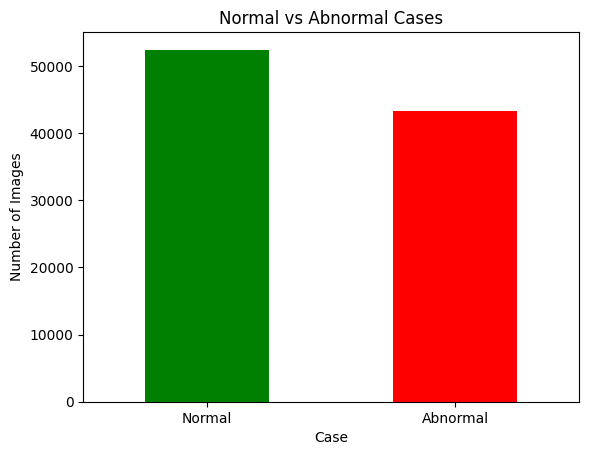

In [ ]:
analysis_data["Case"] = analysis_data["finding_labels"].apply(
    lambda x: "Normal" if x == "No Finding" else "Abnormal"
)

normal_abnormal_counts = analysis_data["Case"].value_counts()
print(normal_abnormal_counts)

normal_abnormal_counts.plot(
    kind="bar",
    color=["green", "red"],
    title="Normal vs Abnormal Cases"
)
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()



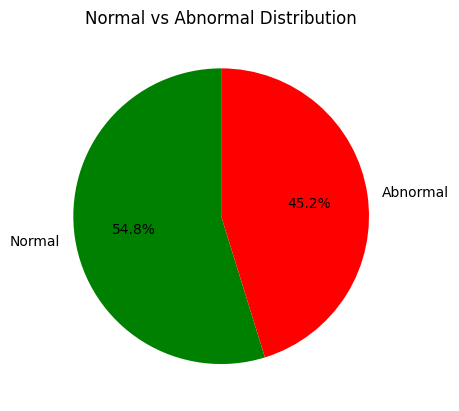

In [ ]:
normal_abnormal_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    colors=["green", "red"]
)
plt.ylabel("")
plt.title("Normal vs Abnormal Distribution")
plt.show()


finding_labels
No Finding            52439
Infiltration          17298
Effusion              11570
Atelectasis           10128
Nodule                 5492
Mass                   4966
Pneumothorax           4591
Pleural_Thickening     2959
Cardiomegaly           2397
Emphysema              2174
Fibrosis               1481
Pneumonia              1190
Hernia                  201
Name: count, dtype: int64


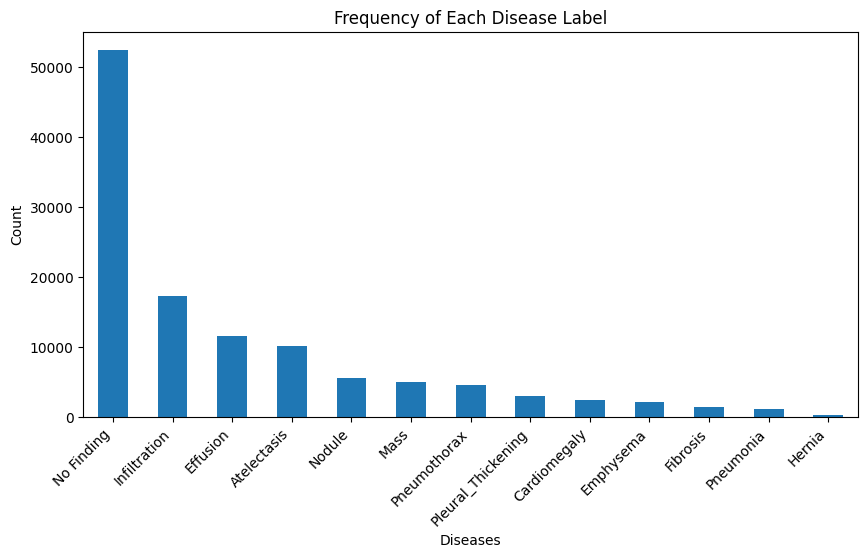

In [ ]:
all_labels = (
    analysis_data["finding_labels"]
    .str.split("|")
    .explode()
)

label_frequency = all_labels.value_counts()
print(label_frequency)

label_frequency.plot(kind="bar", figsize=(10,5))
plt.title("Frequency of Each Disease Label")
plt.ylabel("Count")
plt.xlabel("Diseases")
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
analysis_data["num_labels"] = analysis_data["finding_labels"].apply(
    lambda x: len(x.split("|"))
)

multi_diag_percentage = (analysis_data["num_labels"] > 1).mean() * 100
print(f"Patients with multiple diagnoses: {multi_diag_percentage:.2f}%")



Patients with multiple diagnoses: 16.48%


count    27966.000000
mean         3.422406
std          6.381151
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        156.000000
Name: Image Index, dtype: float64
Patients with multiple images: 12362


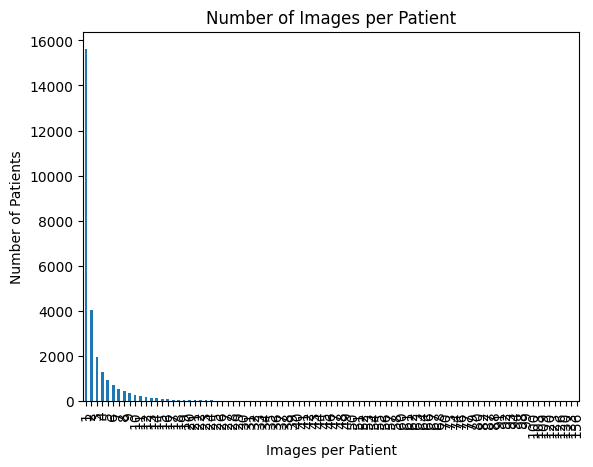

In [ ]:
images_per_patient = analysis_data.groupby("Patient ID")["Image Index"].count()

images_per_patient.value_counts().sort_index().plot(kind="bar")
plt.title("Number of Images per Patient")
plt.xlabel("Images per Patient")
plt.ylabel("Number of Patients")
plt.show()


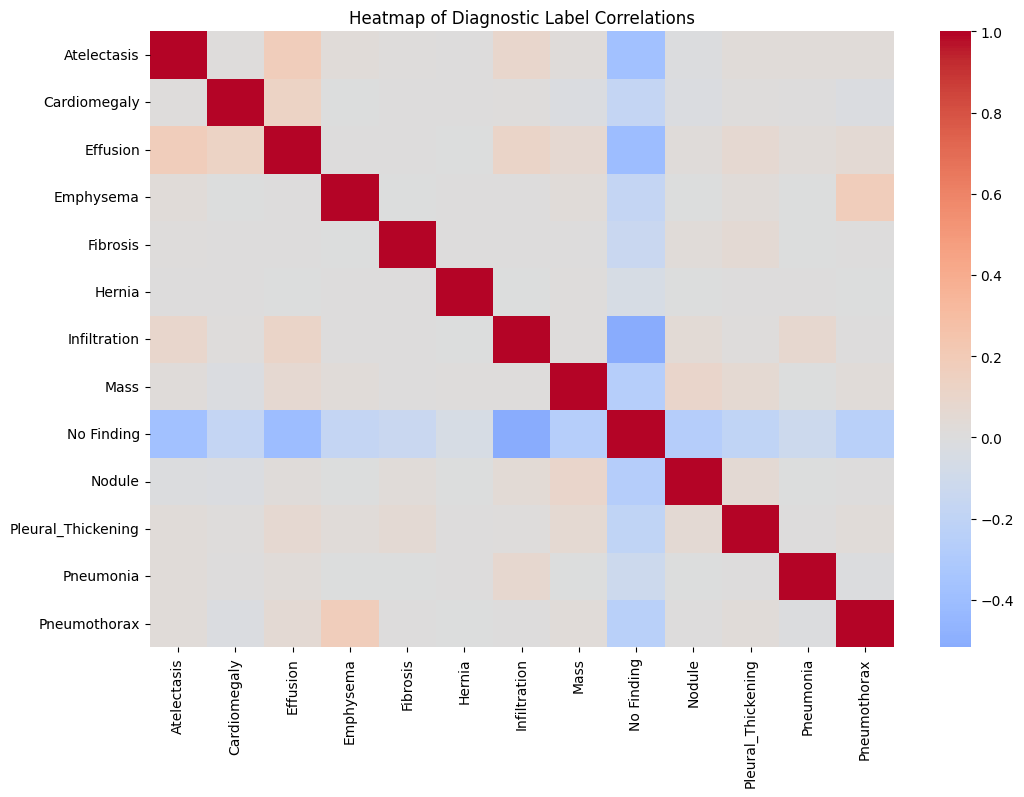

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

label_matrix = mlb.fit_transform(
    analysis_data["finding_labels"].str.split("|")
)

label_df = pd.DataFrame(label_matrix, columns=mlb.classes_)
label_corr = label_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(label_corr, cmap="coolwarm", center=0)
plt.title("Heatmap of Diagnostic Label Correlations")
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score


In [ ]:
CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/outputs/FINAL_clean_data.csv"
IMAGE_ROOT = "/content/drive/MyDrive/Colab Notebooks/real data/images_0013/images"

df = pd.read_csv(CSV_PATH)

# split labels
df["finding_labels"] = df["finding_labels"].apply(lambda x: x.split("|"))

# build image paths
df["image_path"] = df["Image Index"].astype(str).apply(
    lambda x: os.path.join(IMAGE_ROOT, x)
)

df["image_exists"] = df["image_path"].apply(os.path.exists)
df = df[df["image_exists"]].reset_index(drop=True)

print("Images that exist:", len(df))


Images that exist: 1004


In [ ]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["finding_labels"])

NUM_CLASSES = len(mlb.classes_)
print("Number of disease labels:", NUM_CLASSES)


Number of disease labels: 12


In [ ]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

train_idx, test_idx = next(
    gss.split(df, Y, groups=df["Patient ID"])
)

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

Y_train = Y[train_idx]
Y_test  = Y[test_idx]

print("Train:", len(train_df))
print("Test:", len(test_df))


Train: 820
Test: 184


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
X_train, Y_train_mem = [], []
X_test,  Y_test_mem  = [], []

print("Loading TRAIN images into memory...")
for i in tqdm(range(len(train_df))):
    try:
        img = Image.open(train_df.loc[i, "image_path"]).convert("RGB")
        img = transform(img)
        X_train.append(img)
        Y_train_mem.append(torch.tensor(Y_train[i], dtype=torch.float32))
    except:
        continue

print("Loading TEST images into memory...")
for i in tqdm(range(len(test_df))):
    try:
        img = Image.open(test_df.loc[i, "image_path"]).convert("RGB")
        img = transform(img)
        X_test.append(img)
        Y_test_mem.append(torch.tensor(Y_test[i], dtype=torch.float32))
    except:
        continue


Loading TRAIN images into memory...


100%|██████████| 820/820 [08:43<00:00,  1.57it/s]


Loading TEST images into memory...


100%|██████████| 184/184 [01:45<00:00,  1.74it/s]


In [ ]:
X_train = torch.stack(X_train)
Y_train_mem = torch.stack(Y_train_mem)

X_test = torch.stack(X_test)
Y_test_mem = torch.stack(Y_test_mem)

print("Final train samples:", X_train.shape[0])
print("Final test samples:", X_test.shape[0])


Final train samples: 83
Final test samples: 27


In [ ]:
train_loader = DataLoader(
    TensorDataset(X_train, Y_train_mem),
    batch_size=8,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    TensorDataset(X_test, Y_test_mem),
    batch_size=8,
    shuffle=False,
    num_workers=0
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {total_loss/len(train_loader):.4f}")


100%|██████████| 11/11 [00:23<00:00,  2.16s/it]


Epoch 1/3 | Train Loss: 0.6291


100%|██████████| 11/11 [00:22<00:00,  2.05s/it]


Epoch 2/3 | Train Loss: 0.3984


100%|██████████| 11/11 [00:22<00:00,  2.06s/it]

Epoch 3/3 | Train Loss: 0.2586


In [ ]:
model.eval()
preds, targets = [], []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        outputs = torch.sigmoid(model(imgs)).cpu().numpy()
        preds.append(outputs)
        targets.append(labels.numpy())

preds = np.vstack(preds)
targets = np.vstack(targets)

auc = roc_auc_score(targets, preds, average="micro")
print("TRAIN MICRO-AUROC:", auc)

TRAIN MICRO-AUROC: 0.9902390800418164


In [ ]:
torch.save({
    "model_state": model.state_dict(),
    "label_names": mlb.classes_
}, "xray_multilabel_model.pth")


In [ ]:
checkpoint = torch.load(
    "xray_multilabel_model.pth",
    map_location=device,
    weights_only=False
)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(checkpoint["label_names"]))
model.load_state_dict(checkpoint["model_state"])
model = model.to(device)
model.eval()

label_names = checkpoint["label_names"]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

def predict_xray(image_path, threshold=0.5):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # add batch dim

    with torch.no_grad():
        logits = model(img)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    results = {
        label_names[i]: float(probs[i])
        for i in range(len(label_names))
        if probs[i] >= threshold
    }

    return results


In [ ]:
def batch_predict(indices, threshold=0.5):
    imgs = torch.stack([X_train[i] for i in indices]).to(device)

    with torch.no_grad():
        probs = torch.sigmoid(model(imgs)).cpu().numpy()

    for k, idx in enumerate(indices):
        print("=" * 60)
        print(f"Image index: {idx}")

        age = train_df.loc[idx, "patient_age"] if "patient_age" in train_df.columns else "NA"
        gender = train_df.loc[idx, "gender"] if "gender" in train_df.columns else "NA"
        view = train_df.loc[idx, "view_position"] if "view_position" in train_df.columns else "NA"

        print(f"Age: {age}, Gender: {gender}, View: {view}")
        print("Detected findings:")

        found = False
        for i, p in enumerate(probs[k]):
            if p >= threshold:
                print(f"• {label_names[i]} → {p:.3f}")
                found = True

        if not found:
            print("• Normal")


In [ ]:
def predict_raw(idx):
    img = X_train[idx].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    print(f"\nRAW probabilities for image index {idx}:")
    for i, p in enumerate(probs):
        print(f"{label_names[i]:25s} : {p:.4f}")


Predictions shape: (83, 12)
Targets shape: (83, 12)


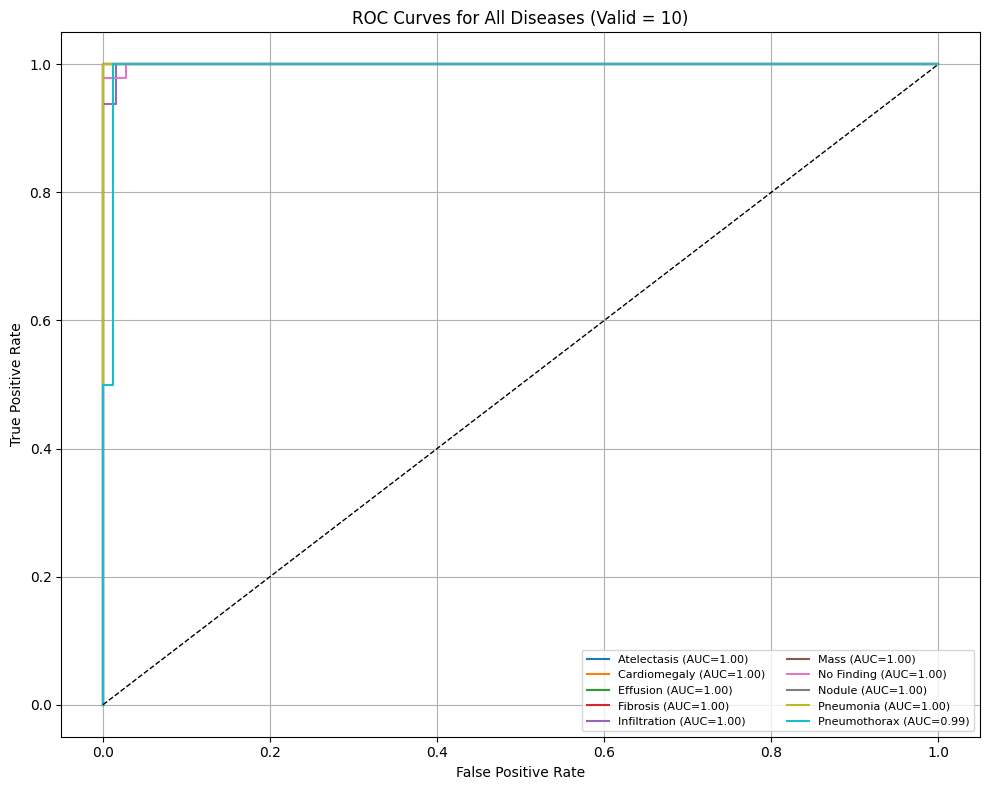


Per-Disease AUROC Summary
---------------------------------------------
Atelectasis               : 1.000
Cardiomegaly              : 1.000
Effusion                  : 1.000
Emphysema                 : N/A (single class)
Fibrosis                  : 1.000
Infiltration              : 0.999
Mass                      : 1.000
No Finding                : 0.999
Nodule                    : 1.000
Pleural_Thickening        : N/A (single class)
Pneumonia                 : 1.000
Pneumothorax              : 0.994


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset

# --------------------------------------------------
# STEP 1: Get predictions on training data
# --------------------------------------------------

model.eval()
preds, targets = [], []

with torch.no_grad():
    for imgs, labels in DataLoader(
        TensorDataset(X_train, Y_train_mem),
        batch_size=16,
        shuffle=False
    ):
        imgs = imgs.to(device)
        outputs = torch.sigmoid(model(imgs)).cpu().numpy()
        preds.append(outputs)
        targets.append(labels.numpy())

preds = np.vstack(preds)
targets = np.vstack(targets)

print("Predictions shape:", preds.shape)
print("Targets shape:", targets.shape)

# --------------------------------------------------
# STEP 2: Plot ROC curves for ALL diseases
# --------------------------------------------------

plt.figure(figsize=(10, 8))

valid_disease_count = 0
auc_scores = {}

for i, disease in enumerate(label_names):

    # AUROC undefined if only one class present
    if len(np.unique(targets[:, i])) < 2:
        auc_scores[disease] = None
        continue

    fpr, tpr, _ = roc_curve(targets[:, i], preds[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        label=f"{disease} (AUC={roc_auc:.2f})"
    )

    auc_scores[disease] = roc_auc
    valid_disease_count += 1

# Diagonal reference line
plt.plot([0, 1], [0, 1], "k--", lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves for All Diseases (Valid = {valid_disease_count})")
plt.legend(fontsize=8, loc="lower right", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# STEP 3: Print per-disease AUROC table
# --------------------------------------------------

print("\nPer-Disease AUROC Summary")
print("-" * 45)

for disease, score in auc_scores.items():
    if score is None:
        print(f"{disease:25s} : N/A (single class)")
    else:
        print(f"{disease:25s} : {score:.3f}")


In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gradcam_generate(model, img, target_class, target_layer):
    """
    Hook-free Grad-CAM implementation
    """
    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # Register hooks TEMPORARILY
    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    # Forward + backward
    model.zero_grad()
    output = model(img)
    score = output[0, target_class]
    score.backward()

    # Compute Grad-CAM
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)
    cam = F.relu(cam)
    cam = cam / (cam.max() + 1e-8)

    # Remove hooks immediately (IMPORTANT)
    fh.remove()
    bh.remove()

    return cam[0].detach().cpu().numpy()


In [ ]:
from sklearn.metrics import roc_auc_score

model.eval()
preds, targets = [], []

with torch.no_grad():
    for imgs, labels in DataLoader(
        TensorDataset(X_train, Y_train_mem),
        batch_size=16,
        shuffle=False
    ):
        imgs = imgs.to(device)
        outputs = torch.sigmoid(model(imgs)).cpu().numpy()
        preds.append(outputs)
        targets.append(labels.numpy())

preds = np.vstack(preds)
targets = np.vstack(targets)


In [ ]:
from torchvision import transforms
from PIL import Image

infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
import cv2
import numpy as np
from PIL import Image

def safe_load_image(path):
    try:
        # OpenCV read (much more stable with Drive)
        img = cv2.imread(path)
        if img is None:
            raise ValueError("cv2.imread failed")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return Image.fromarray(img)

    except Exception as e:
        print(f" Skipping image due to read error: {path}")
        return None


In [ ]:
for idx in range(50):

    print("=" * 70)
    print(f"Image index: {idx}")

    age = train_df.loc[idx, "patient_age"] if "patient_age" in train_df.columns else "NA"
    gender = train_df.loc[idx, "gender"] if "gender" in train_df.columns else "NA"
    view = train_df.loc[idx, "view_position"] if "view_position" in train_df.columns else "NA"

    print(f"Patient Age : {age}")
    print(f"Gender      : {gender}")
    print(f"View        : {view}")

    img = X_train[idx].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    print("\nRaw Output Probabilities (%):")
    for i, p in enumerate(probs):
        print(f"{label_names[i]:25s} : {p*100:.2f}%")

    detected = [(i, p) for i, p in enumerate(probs) if p >= 0.3]

    print("\nDetected Findings (threshold = 30%):")
    if not detected:
        print("• Normal (no abnormal findings)")
        continue

    for i, p in detected:
        print(f"• {label_names[i]} → {p*100:.2f}%")

    top_class = max(detected, key=lambda x: x[1])[0]

    # ---- Grad-CAM for TOP prediction ----
    top_class = max(detected, key=lambda x: x[1])[0]

    cam = gradcam_generate(model=model, img=img, target_class=top_class, target_layer=model.layer4)
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    original = X_train[idx].permute(1, 2, 0).cpu().numpy()
    original = (original - original.min()) / (original.max() - original.min() + 1e-8)

    overlay = 0.6 * original + 0.4 * heatmap / 255.0

    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM → {label_names[top_class]}")
    plt.axis("off")
    plt.show()


User Image 1: /content/drive/MyDrive/Colab Notebooks/real data/images_0013/images/00003929_000.png
 Skipping image due to read error: /content/drive/MyDrive/Colab Notebooks/real data/images_0013/images/00003929_000.png


In [ ]:
#For user input images

# user_images = [
#     "/content/drive/MyDrive/Colab Notebooks/real data/images_0013/images/00003929_000.png"
# ]

# for idx, img_path in enumerate(user_images):

#     print("=" * 70)
#     print(f"User Image {idx+1}: {img_path}")

#     # ---- Load image ----
#     img_pil = safe_load_image(img_path)
#     if img_pil is None:
#       continue  # skip this image safely

#     img_tensor = infer_transform(img_pil).unsqueeze(0).to(device)

#     # ---- Inference ----
#     with torch.no_grad():
#         logits = model(img_tensor)
#         probs = torch.sigmoid(logits).cpu().numpy()[0]

#     # ---- Raw probabilities ----
#     print("\nRaw Output Probabilities (%):")
#     for i, p in enumerate(probs):
#         print(f"{label_names[i]:25s} : {p*100:.2f}%")

#     # ---- Thresholding ----
#     detected = [(i, p) for i, p in enumerate(probs) if p >= 0.3]

#     print("\nDetected Findings (threshold = 30%):")
#     if not detected:
#         print("• Normal (no abnormal findings)")
#         continue

#     for i, p in detected:
#         print(f"• {label_names[i]} → {p*100:.2f}%")

#     # ---- Grad-CAM only if abnormal ----
#     top_class = max(detected, key=lambda x: x[1])[0]

#     cam = gradcam_generate(
#         model=model,
#         img=img_tensor,
#         target_class=top_class,
#         target_layer=model.layer4
#     )

#     # ---- Reddish-brown overlay ----
#     cam = cam - cam.min()
#     cam = cam / (cam.max() + 1e-8)
#     cam = cv2.resize(cam, (224, 224))

#     CAM_THRESHOLD = 0.4
#     cam_mask = cam > CAM_THRESHOLD

#     original = np.array(img_pil.resize((224, 224))) / 255.0

#     brown_overlay = np.zeros_like(original)
#     brown_overlay[..., 0] = cam * 0.9
#     brown_overlay[..., 1] = cam * 0.35
#     brown_overlay[..., 2] = cam * 0.15

#     overlay = original.copy()
#     overlay[cam_mask] = (
#         0.65 * original[cam_mask] +
#         0.35 * brown_overlay[cam_mask]
#     )

#     plt.figure(figsize=(4, 4))
#     plt.imshow(overlay)
#     plt.title(f"Grad-CAM → {label_names[top_class]}")
#     plt.axis("off")
#     plt.show()
